In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing_abundant import graph_dict
from AttentiveFP.AttentiveLayers_abundant import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  1128
number of successfully processed smiles:  1128


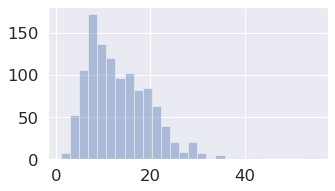

In [4]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "../data/delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 64

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
K = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/delaney-processed_abundant.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    

In [8]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

262533
preprocess.0.linear.weight torch.Size([64, 55])
preprocess.0.linear.bias torch.Size([64])
preprocess.0.bn.weight torch.Size([64])
preprocess.0.bn.bias torch.Size([64])
propagate.0.encoder.0.linear.weight torch.Size([4096, 10])
propagate.0.encoder.0.linear.bias torch.Size([4096])
propagate.0.encoder.0.bn.weight torch.Size([4096])
propagate.0.encoder.0.bn.bias torch.Size([4096])
propagate.0.align.weight torch.Size([1, 128])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([64, 64])
propagate.0.attend.linear.bias torch.Size([64])
propagate.0.attend.bn.weight torch.Size([64])
propagate.0.attend.bn.bias torch.Size([64])
propagate.0.gru.weight_ih torch.Size([192, 64])
propagate.0.gru.weight_hh torch.Size([192, 64])
propagate.0.gru.bias_ih torch.Size([192])
propagate.0.gru.bias_hh torch.Size([192])
propagate.1.encoder.0.linear.weight torch.Size([4096, 10])
propagate.1.encoder.0.linear.bias torch.Size([4096])
propagate.1.encoder.0.bn.weight torch.Size([

In [9]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [10]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 0
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [11]:

log = Logger()
log.open(f'{prefix_filename}_abundant_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train MSE |  valid MSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_abundant_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_MSE"] = 9e8
    best_param["valid_MSE"] = 9e8
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))
        
        if train_MSE < best_param["train_MSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_MSE"] = train_MSE
        if valid_MSE < best_param["valid_MSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_MSE"] = valid_MSE
            if valid_MSE < 0.35:
                 torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
            break

    log2.write('fold | epoch | train_MSE | valid MSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"]))
    
    

epoch | loss | train MSE |  valid MSE |  time 
  0   | 7.8384  | 3.5088  | 4.0675  |  0 hr 00 min 
  1   | 2.1160  | 2.3818  | 3.0310  |  0 hr 00 min 
  2   | 1.7716  | 1.9498  | 2.5186  |  0 hr 00 min 
  3   | 1.4848  | 1.9440  | 2.3969  |  0 hr 00 min 
  4   | 1.0374  | 1.6764  | 2.1231  |  0 hr 00 min 
  5   | 0.9206  | 1.5691  | 1.8151  |  0 hr 00 min 
  6   | 0.7950  | 1.3417  | 1.4933  |  0 hr 00 min 
  7   | 0.8779  | 0.8495  | 0.9549  |  0 hr 00 min 
  8   | 0.6747  | 1.0210  | 0.9870  |  0 hr 00 min 
  9   | 0.6613  | 0.6401  | 0.6472  |  0 hr 00 min 
 10   | 0.5651  | 0.4953  | 0.6161  |  0 hr 00 min 
 11   | 0.5623  | 0.4860  | 0.5689  |  0 hr 00 min 
 12   | 0.5069  | 0.4468  | 0.5153  |  0 hr 00 min 
 13   | 0.4417  | 0.4216  | 0.5181  |  0 hr 00 min 
 14   | 0.4488  | 0.3672  | 0.4908  |  0 hr 00 min 
 15   | 0.4194  | 0.3634  | 0.4658  |  0 hr 00 min 
 16   | 0.4043  | 0.3091  | 0.4466  |  0 hr 00 min 
 17   | 0.3730  | 0.2936  | 0.4490  |  0 hr 00 min 
 18   | 0.3942  |

 49   | 0.2904  | 0.1067  | 0.3280  |  0 hr 07 min 
 50   | 0.2211  | 0.1194  | 0.3382  |  0 hr 07 min 
 51   | 0.2008  | 0.1108  | 0.3717  |  0 hr 08 min 
 52   | 0.2484  | 0.1367  | 0.3969  |  0 hr 08 min 
 53   | 0.1980  | 0.1263  | 0.3435  |  0 hr 08 min 
 54   | 0.2077  | 0.1138  | 0.3568  |  0 hr 08 min 
 55   | 0.1935  | 0.1276  | 0.3610  |  0 hr 08 min 
 56   | 0.1909  | 0.1350  | 0.3583  |  0 hr 08 min 
 57   | 0.1648  | 0.1238  | 0.3535  |  0 hr 08 min 
 58   | 0.1914  | 0.1106  | 0.3535  |  0 hr 08 min 
 59   | 0.1746  | 0.0957  | 0.3337  |  0 hr 08 min 
 60   | 0.1862  | 0.1471  | 0.3955  |  0 hr 08 min 
 61   | 0.1986  | 0.1183  | 0.3649  |  0 hr 08 min 
 62   | 0.1502  | 0.1308  | 0.4079  |  0 hr 08 min 
 63   | 0.2203  | 0.0874  | 0.3707  |  0 hr 08 min 
 64   | 0.2304  | 0.1039  | 0.3626  |  0 hr 08 min 
 65   | 0.1614  | 0.1089  | 0.3487  |  0 hr 08 min 
 66   | 0.1784  | 0.1065  | 0.3851  |  0 hr 08 min 
 67   | 0.1773  | 0.1197  | 0.3562  |  0 hr 08 min 
 68   | 0.17

  5   | 0.7794  | 1.3788  | 1.4779  |  0 hr 15 min 
  6   | 0.7704  | 1.0808  | 1.1267  |  0 hr 15 min 
  7   | 0.7567  | 1.2636  | 1.1182  |  0 hr 15 min 
  8   | 0.6292  | 0.7747  | 0.7763  |  0 hr 15 min 
  9   | 0.5366  | 0.6344  | 0.6653  |  0 hr 15 min 
 10   | 0.4937  | 0.4135  | 0.4726  |  0 hr 15 min 
 11   | 0.4976  | 0.4441  | 0.4626  |  0 hr 16 min 
 12   | 0.4947  | 0.3838  | 0.4247  |  0 hr 16 min 
 13   | 0.4688  | 0.3939  | 0.4397  |  0 hr 16 min 
 14   | 0.4272  | 0.3271  | 0.3598  |  0 hr 16 min 
 15   | 0.4095  | 0.3742  | 0.4015  |  0 hr 16 min 
 16   | 0.4187  | 0.3500  | 0.3682  |  0 hr 16 min 
 17   | 0.4348  | 0.5035  | 0.5275  |  0 hr 16 min 
 18   | 0.4387  | 0.3677  | 0.3963  |  0 hr 16 min 
 19   | 0.5058  | 0.3634  | 0.4181  |  0 hr 16 min 
 20   | 0.4615  | 0.3343  | 0.3443  |  0 hr 16 min 
 21   | 0.4414  | 0.3375  | 0.4000  |  0 hr 16 min 
 22   | 0.4101  | 0.3196  | 0.4171  |  0 hr 16 min 
 23   | 0.3649  | 0.2907  | 0.3468  |  0 hr 16 min 
 24   | 0.33

In [12]:
# # evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
# test_MAE, test_MSE = eval(model, test_df)
# print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

In [13]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)